# [Milvus 벡터 데이터베이스](https://milvus.io/ko/intro)


## 1. Milvus란?
> Milvus는 오픈소스 벡터 데이터베이스로, 대규모 벡터 검색과 머신러닝 애플리케이션을 위한 고성능 데이터 저장소입니다.

### 주요 특징
- **고성능**: 밀리초 단위의 벡터 검색 성능
- **확장성**: 수십억 개의 벡터를 처리할 수 있는 수평적 확장
- **다양한 인덱스**: IVF, HNSW, ANNOY 등 다양한 벡터 인덱스 지원
- **클라우드 네이티브**: Kubernetes 환경에서 완벽하게 동작
- **다양한 API**: RESTful API, Python SDK, Java SDK 등 제공

### RAG에서의 활용
- 문서 임베딩 벡터 저장
- 의미 기반 유사 문서 검색
- 하이브리드 검색 (벡터 + 키워드)
- 멀티모달 검색 지원

### Milvus는 어떻게 작동하나요?
> Milvus는 벡터 데이터를 효율적으로 처리하고 확장성, 조정 가능성 및 데이터 격리를 보장하기 위해 설계된 다층 아키텍처를 중심으로 구축되었습니다.

- 액세스 계층
    - 이 계층은 외부 요청의 최초 접점 역할을 하며 스테이트리스 프록시를 사용하여 클라이언트 연결 관리, 정적 검증 및 동적 검사를 수행합니다. 이러한 프록시는 또한 로드 밸런싱을 처리하며 Milvus의 포괄적인 API 스위트를 구현하는 데 중요합니다. 다운스트림 서비스가 요청을 처리한 후 액세스 계층은 응답을 사용자에게 라우팅합니다.

- 코디네이터 서비스
    - 중앙 명령으로 작동하여 4개의 코디네이터를 통해 로드 밸런싱 및 데이터 관리를 조정합니다. 이를 통해 데이터, 쿼리 및 인덱스의 효율적인 관리가 가능합니다.

- 워커 노드
    - 실제 작업 실행을 담당하며 코디네이터의 명령을 실행하는 확장 가능한 포드입니다. 이를 통해 Milvus는 변화하는 데이터, 쿼리 및 인덱싱 요구에 동적으로 조정하여 시스템의 확장성과 조정 가능성을 지원합니다.

- 객체 스토리지 계층: 데이터 지속성에 필수적이며 다음 요소로 구성됩니다.
    - Meta store: 메타데이터 스냅샷 및 시스템 상태 확인을 위해 etcd 사용합니다.
    - Log broker: Pulsar 또는 RocksDB를 활용하여 스트리밍 데이터 지속성 및 복구를 위해 사용합니다.
    - Object storage: AWS S3, Azure Blob Storage, MinIO와 같은 서비스를 지원하여 로그 스냅샷, 인덱스 파일 및 쿼리 결과를 저장합니다.

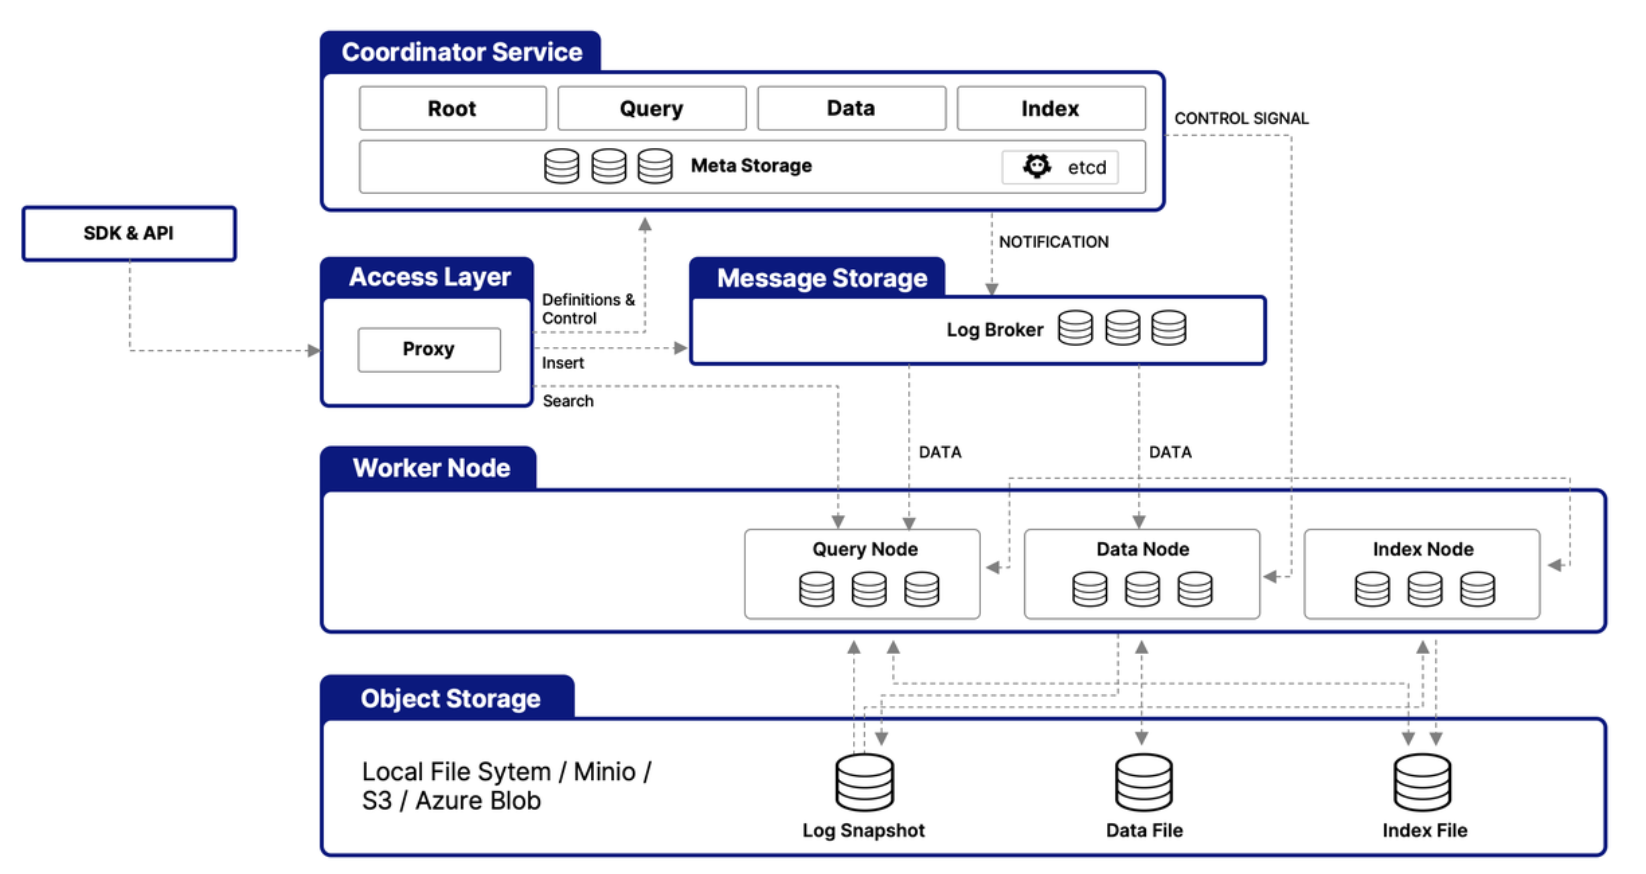

## 2. Milvus 설치 및 설정

### Docker를 이용한 설치 (권장)

```bash
# Milvus standalone 버전 실행
docker run -d --name milvus-standalone \
  -p 19530:19530 \
  -p 9091:9091 \
  -v $(pwd)/volumes/milvus:/var/lib/milvus \
  milvusdb/milvus:latest \
  milvus run standalone
```

### Python 패키지 설치

```bash
pip install pymilvus
pip install langchain-milvus
```


## 3. 기본 Milvus 사용법

### 3.1 연결 설정


In [ ]:
from pymilvus import connections, Collection, CollectionSchema, FieldSchema, DataType
import numpy as np

# 인증을 사용한 Milvus 접속
connections.connect(
    alias="milvus_dev",           # 연결 이름, 여러 Milvus 서버를 사용할 때 구분 가능
    host="localhost",          # Milvus 서버 주소 (Docker에서 localhost)
    port="19530",              # Milvus gRPC 포트
    user="root",               # 인증 활성화 시 Milvus 관리자 계정
    password="mysecurepassword" # 인증 활성화 시 Milvus 비밀번호
)

print("Milvus 연결 성공!")


Milvus 연결 성공!


### 3.2 컬렉션 생성
> connections을 통해 Milvus 연결 후 컬렉션 생성 가능 

In [ ]:
# 컬렉션 스키마 정의
def create_collection():
    # 필드 정의
    fields = [
        FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=1000),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=768)
    ]
    
    # 스키마 생성
    schema = CollectionSchema(fields, "문서 임베딩을 위한 컬렉션")
    
    # 컬렉션 생성
    collection_name = "document_embeddings"
    collection = Collection(name=collection_name # 컬렉션 이름
                            , schema=schema # 스키마
                            , using="milvus_dev" # 위에서 정의한 connections의 alias
    )
    
    return collection


In [3]:
# 컬렉션 생성
collection = create_collection()
print(f"컬렉션 '{collection.name}' 생성 완료")


컬렉션 'document_embeddings' 생성 완료


### 3.3 인덱스 생성


In [4]:
# 벡터 인덱스 생성
def create_index(collection):
    # IVF_FLAT 인덱스 생성 (정확한 검색을 위한 기본 인덱스)
    index_params = {
        "metric_type": "L2",  # 유클리드 거리
        "index_type": "IVF_FLAT",
        "params": {"nlist": 1024}
    }
    
    # 임베딩 필드에 인덱스 생성
    collection.create_index("embedding", index_params)
    print("인덱스 생성 완료")
    

In [5]:
# 인덱스 생성
create_index(collection)


인덱스 생성 완료


### 3.4 데이터 삽입


In [6]:
# 샘플 데이터 생성 및 삽입
def insert_data(collection):
    # 샘플 텍스트 데이터
    texts = [
        "인공지능은 컴퓨터 과학의 한 분야입니다.",
        "머신러닝은 데이터로부터 패턴을 학습합니다.",
        "딥러닝은 신경망을 사용한 머신러닝입니다.",
        "자연어처리는 컴퓨터가 인간의 언어를 이해하는 기술입니다."
    ]
    
    # 샘플 임베딩 벡터 생성 (실제로는 임베딩 모델 사용)
    embeddings = [np.random.random(768).tolist() for _ in range(len(texts))]
    
    # 데이터 준비
    data = [
        texts,
        embeddings
    ]
    
    # 컬렉션에 데이터 삽입
    collection.insert(data)
    collection.flush()  # 디스크에 저장
    
    print(f"{len(texts)}개 문서 삽입 완료")
    

In [7]:
# 데이터 삽입
insert_data(collection)


4개 문서 삽입 완료


### 3.5 벡터 검색


In [8]:
# 벡터 검색 수행
def search_vectors(collection, query_vector, top_k=3):
    # 컬렉션 로드
    collection.load()
    
    # 검색 파라미터
    search_params = {
        "metric_type": "L2",
        "params": {"nprobe": 10}
    }
    
    # 벡터 검색 실행
    results = collection.search(
        data=[query_vector],
        anns_field="embedding",
        param=search_params,
        limit=top_k,
        output_fields=["text"]
    )
    
    return results


In [10]:
# 검색 쿼리 벡터 생성
query_vector = np.random.random(768).tolist()
query_vector[:5]

[0.8848741272221452,
 0.07935004281140279,
 0.9490842900193432,
 0.3780033731644853,
 0.021833429180943886]

In [11]:
# 검색 수행
results = search_vectors(collection, query_vector, top_k=3)

# 결과 출력
print("검색 결과:")
for i, result in enumerate(results[0]):
    print(f"{i+1}. 거리: {result.distance:.4f}")
    print(f"   텍스트: {result.entity.get('text')}")


검색 결과:
1. 거리: 129.9787
   텍스트: 자연어처리는 컴퓨터가 인간의 언어를 이해하는 기술입니다.
2. 거리: 130.4242
   텍스트: 머신러닝은 데이터로부터 패턴을 학습합니다.
3. 거리: 130.5151
   텍스트: 인공지능은 컴퓨터 과학의 한 분야입니다.


## 4. LangChain과 Milvus 연동


## OpenAI Key 등록
- [OpenAI Key 발급](https://platform.openai.com/api-keys)

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'sk-proj-yourkeyhere'


### 4.1 LangChain Milvus VectorStore 설정


In [18]:
from langchain_milvus import Milvus
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

In [24]:
# OpenAI 임베딩 모델 설정
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small"
)


In [25]:
# Milvus VectorStore 생성
vectorstore = Milvus(
    embedding_function=embeddings,
    collection_name="rag_documents",
    connection_args={
        "host": "localhost",
        "port": "19530"
    }
)

print("LangChain Milvus VectorStore 설정 완료")


LangChain Milvus VectorStore 설정 완료


### 4.2 문서 저장 및 검색


In [26]:
# 샘플 문서 생성
documents = [
    Document(
        page_content="인공지능(AI)은 인간의 지능을 모방하여 학습, 추론, 문제해결을 수행하는 기술입니다.",
        metadata={"source": "ai_intro.txt", "topic": "AI"}
    ),
    Document(
        page_content="머신러닝은 데이터로부터 패턴을 학습하여 예측이나 분류를 수행하는 AI의 한 분야입니다.",
        metadata={"source": "ml_intro.txt", "topic": "ML"}
    ),
    Document(
        page_content="딥러닝은 인공신경망을 사용하여 복잡한 패턴을 학습하는 머신러닝의 한 분야입니다.",
        metadata={"source": "dl_intro.txt", "topic": "DL"}
    )
]

# 문서를 벡터스토어에 추가
vectorstore.add_documents(documents)
print(f"{len(documents)}개 문서가 벡터스토어에 저장되었습니다.")


3개 문서가 벡터스토어에 저장되었습니다.


In [27]:
# 유사 문서 검색
query = "인공신경망에 대해 알려주세요"
results = vectorstore.similarity_search(query, k=2)

print(f"쿼리: {query}")
print("\n검색 결과:")
for i, doc in enumerate(results):
    print(f"{i+1}. {doc.page_content}")
    print(f"   메타데이터: {doc.metadata}")


쿼리: 인공신경망에 대해 알려주세요

검색 결과:
1. 인공지능(AI)은 인간의 지능을 모방하여 학습, 추론, 문제해결을 수행하는 기술입니다.
   메타데이터: {'pk': 461116581730065540, 'source': 'ai_intro.txt', 'topic': 'AI'}
2. 딥러닝은 인공신경망을 사용하여 복잡한 패턴을 학습하는 머신러닝의 한 분야입니다.
   메타데이터: {'pk': 461116581730065542, 'source': 'dl_intro.txt', 'topic': 'DL'}


### 4.3 RAG 체인 구성


In [28]:
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

# LLM 설정
llm = ChatOpenAI(
    model="gpt-5-nano"
)


In [29]:
# RAG 체인 구성
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(search_kwargs={"k": 2})
)


In [33]:
# 질문 답변 실행
question = "머신러닝과 딥러닝의 차이점은 무엇인가요?"
answer = qa_chain.invoke(question)

print(f"질문: {answer['query']}")
print(f"답변: {answer['result']}")


질문: 머신러닝과 딥러닝의 차이점은 무엇인가요?
답변: 다음과 같이 차이를 정리할 수 있어요.

- 정의와 관계
  - 머신러닝: 데이터로부터 패턴을 학습해 예측/분류를 수행하는 AI의 한 분야.
  - 딥러닝: 머신러닝의 하위 분야로, 다층 인공신경망을 사용해 데이터에서 특징을 자동으로 학습하고 표현을 점점 더 깊게 학습하는 방식.

- 특징 추출 방식
  - 전통적인 머신러닝: 특징 공학(feature engineering)을 사람이 직접 설계하고 선택하는 경우가 많음.
  - 딥러닝: 다층 신경망이 자동으로 특징을 학습(표현 학습)하기 때문에 초기 특징 설계 의존도가 낮음.

- 데이터와 계산 자원
  - 머신러닝: 상대적으로 적은 데이터로도 잘 동작하는 알고리즘이 많고 CPU도 충분한 경우가 많음.
  - 딥러닝: 대규모 데이터와 강력한 하드웨어(GPU/TPU)가 필요해 학습이 상대적으로 자원 집약적임.

- 모델 구조와 예시
  - 머신러닝 알고리즘의 예: 선형 회귀, 로지스틱 회귀, 결정 트리, 랜덤 포레스트, SVM, k-최근접 이웃 등.
  - 딥러닝 모델의 예: 다층 CNN, RNN/LSTM, 트랜스포머 등처럼 깊이가 큰 뉴럴 네트워크.

- 적용 분야
  - 머신러닝: 구조화된 데이터(tabular data) 예측이나 간단한 패턴 인식에 많이 사용.
  - 딥러닝: 이미지/비디오 인식, 음성 인식, 자연어 처리 등 비정형 데이터에 탁월한 성능을 보임.

- 해석성
  - 머신러닝의 전통 모델들(예: 선형 회귀, 의사결정트리)은 비교적 해석이 쉬움.
  - 딥러닝은 모델이 크고 복잡해 해석이 어려운 경향이 있음(일부 방법은 해석 가능성 연구가 진행 중).

- 언제 무엇을 선택할까
  - 충분한 데이터와 고성능 자원이 있고 비정형 데이터에 최적의 성능이 필요하면 딥러닝을 고려.
  - 데이터가 비교적 적고 해석이 중요하며, 구조화된 데이터에 대해 빠르고 간단한 모델이 필요하면 전통적인 머신러닝 알고리즘을 먼저 시도.

요약하면, 딥러닝은 머신러

## 5. 고급 기능 및 최적화

### 5.1 다양한 인덱스 타입 비교


In [34]:
# HNSW 인덱스 (빠른 검색, 높은 정확도)
hnsw_params = {
    "metric_type": "L2",
    "index_type": "HNSW",
    "params": {"M": 16, "efConstruction": 200}
}

In [35]:
# IVF_SQ8 인덱스 (메모리 효율적, 양호한 성능)
ivf_sq8_params = {
    "metric_type": "L2",
    "index_type": "IVF_SQ8",
    "params": {"nlist": 1024}
}

In [36]:
# ANNOY 인덱스 (빠른 근사 검색, 낮은 메모리 사용)
annoy_params = {
    "metric_type": "L2",
    "index_type": "ANNOY",
    "params": {"n_trees": 100}
}

### 5.2 하이브리드 검색 (벡터 + 키워드)


In [37]:
# 하이브리드 검색 구현
def hybrid_search(collection, query_vector, keyword_filter, top_k=5):
    # 벡터 검색
    vector_results = collection.search(
        data=[query_vector], # 벡터 데이터
        anns_field="embedding", # 임베딩 필드
        param={"metric_type": "L2", "params": {"nprobe": 10}}, # 검색 파라미터
        limit=top_k, # 검색 결과 수
        output_fields=["text", "id"] # 출력 필드
    )
    
    # 키워드 필터링 (실제로는 더 복잡한 필터링 로직 사용)
    filtered_results = []
    for result in vector_results[0]: 
        if keyword_filter.lower() in result.entity.get('text', '').lower():
            filtered_results.append(result)
    
    return filtered_results


In [38]:
# 하이브리드 검색 예제
query_vector = np.random.random(768).tolist()
keyword = "인공지능"

hybrid_results = hybrid_search(collection, query_vector, keyword, top_k=3)

print(f"하이브리드 검색 결과 (키워드: '{keyword}'):")
for i, result in enumerate(hybrid_results):
    print(f"{i+1}. {result.entity.get('text')}")
    print(f"   거리: {result.distance:.4f}")


하이브리드 검색 결과 (키워드: '인공지능'):
1. 인공지능은 컴퓨터 과학의 한 분야입니다.
   거리: 137.4678


### 5.3 성능 모니터링 및 최적화


In [39]:
import time

# 성능 측정 함수
def measure_search_performance(collection, query_vector, iterations=100):
    collection.load()
    
    start_time = time.time()
    
    for _ in range(iterations):
        results = collection.search(
            data=[query_vector],
            anns_field="embedding",
            param={"metric_type": "L2", "params": {"nprobe": 10}},
            limit=5
        )
    
    end_time = time.time()
    avg_time = (end_time - start_time) / iterations
    
    print(f"평균 검색 시간: {avg_time*1000:.2f}ms")
    print(f"초당 검색 횟수: {1/avg_time:.2f} QPS")
    
    return avg_time


In [40]:
# 성능 측정
query_vector = np.random.random(768).tolist()
measure_search_performance(collection, query_vector, iterations=50)


평균 검색 시간: 1.89ms
초당 검색 횟수: 529.53 QPS


0.0018884563446044922

## 6. 정리 및 모범 사례

### 6.1 Milvus 사용 시 주의사항

1. **인덱스 선택**: 데이터 크기와 검색 정확도 요구사항에 따라 적절한 인덱스 선택
2. **메모리 관리**: 대용량 데이터 처리 시 메모리 사용량 모니터링
3. **컬렉션 설계**: 스키마를 신중하게 설계하여 확장성 고려
4. **백업 전략**: 정기적인 데이터 백업 및 복구 계획 수립

### 6.2 RAG 시스템에서의 활용 팁

1. **청크 크기 최적화**: 문서 분할 시 적절한 청크 크기 설정
2. **임베딩 모델 선택**: 도메인에 맞는 임베딩 모델 사용
3. **하이브리드 검색**: 벡터 검색과 키워드 검색의 조합 활용
4. **캐싱 전략**: 자주 검색되는 쿼리 결과 캐싱

### 6.3 성능 최적화 방법

1. **인덱스 튜닝**: nlist, nprobe 등 파라미터 조정
2. **배치 처리**: 대량 데이터 삽입 시 배치 단위로 처리
3. **컬렉션 분할**: 도메인별로 컬렉션 분리
4. **모니터링**: 지속적인 성능 모니터링 및 튜닝
